# The classification of car images


### The  goal of this work is to predict car class by it's image. In the course of work, various methods will be applied to improve the quality of the model.

## 1. Loading libraries and writing functions

In [191]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-zf8_jw2r
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-zf8_jw2r


In [192]:
!pip install -q efficientnet

In [193]:
!pip install tensorflow_addons -q

In [194]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import csv
import sys
import os
import itertools

# Libraries for augmentations
import albumentations
from ImageDataAugmentor.image_data_augmentor import *

import efficientnet.tfkeras as efn # Efficientnet

# Working with neuronets
import tensorflow as tf
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
from tensorflow.python.client import device_lib
import tensorflow_addons as tfa# using keras layers for augmentation 
from tensorflow.keras.layers.experimental.preprocessing import *

# Libraries for parsing
import requests
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import time
from random import randint
import lxml

# Working with images
from skimage import io
import PIL
from PIL import ImageOps, ImageFilter

#increase the size of graphics
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

#svg graphics look sharper
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sf-dl-car-classification', 'saved-models', 'cars-from-autoru-20072021']
Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [195]:
'''This function will show us images:'''

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

In [196]:
'''Building plots'''

def plot_history(history):
    plt.figure(figsize=(10,5))
    plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure(figsize=(10,5))
    plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [197]:
'''Show images from test generator'''

def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
    generator = itertools.islice(generator, count)
    fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
    for batch, ax in zip(generator, axes):
        if labels:
            img_batch, labels_batch = batch
            img, label = img_batch[0], np.argmax(labels_batch[0]) 
        else:
            img_batch = batch
            img = img_batch[0]
        if not normalized:
            img = img.astype(np.uint8)
        ax.imshow(img)
        if labels:
            ax.set_title(f'Class: {label}')
    plt.show()

In [198]:
'''# With this function we'll get list of links with needed cars in cities: '''

def get_links(i):  
    for c in cities_list:# loop over the cities
        for m in mod_list:# loop over the models
            url = f'https://auto.ru/{c}/cars/{m}/all/?output_type=list&page={i}'
            response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
            
            if response.status_code != 200:# Checking for the good answer
                raise BaseException("response code" + str(response.status_code))
          
            response.encoding = 'utf-8'
            soup = BeautifulSoup(response.text, 'lxml')# read the response
            page = soup.find_all('a',class_="Link ListingItemTitle__link")  
            
            for p in range(len(page)):# scroll over the page 
                if page[p].get('href') not in page_list:# Drop the duplicates
                    page_list.append(page[p].get('href'))# add link
    
    time.sleep(1.2)# waiting to not get banned 

In [199]:
'''This is a function to download images'''
def get_imgs(i):   
    
    for n,url in enumerate(cars.links[cars['class'] ==i]):# loop over the classes  
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        
        if response.status_code != 200:
            raise BaseException("response code" + str(response.status_code))
       
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.text, 'lxml')#read the page
        img = soup.find('img',class_="ImageGalleryDesktop__image")  
        
        try:# if link is "bad" we'l pass it
            #get the image:
            img_data = requests.get('https:' + img.get('src'),verify=False).content
            with open (PATH+f'uploads/{i}/{i}cl{n}.jpg','wb') as handler:# determine unique name 
                handler.write(img_data)# writing image to its folder
        except:
            time.sleep(randint(1,14))
            pass
            
        time.sleep(randint(1,3)) # waiting...'''

In [200]:
device_lib.list_local_devices()# checking for GPU

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 405465861693434484,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15683598464
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2242436933532510432
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [201]:
!pip freeze > requirements.txt

## 2. Input main settings and parse for more images

In [202]:
'''This is default settings. It will be covenient to change them later.''' 

EPOCHS               = 10  # number of epochs for education.
BATCH_SIZE           = 16 # decreasing the batch to not exeed the GPU RAM
LR                   = 1e-3# setting learnig rate
VAL_SPLIT            = 0.2 # proportion of the test sample - 15%

CLASS_NUM            = 10  # number of classes
IMG_SIZE             = 224 # the size of image that we'll give to model 
IMG_CHANNELS         = 3   # RGB has three channels
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sf-dl-car-classification/'# dataset from competition
PATH = "../working/car/" # working directory
MY_PATH = '../input/cars-from-autoru-20072021/'# my dataset with uloaded cars and needed DF
MOD_PATH = '../input/saved-models/'# during the work I've saved the models to re-use them
os.makedirs(PATH,exist_ok=True)

In [203]:
'''Fixing random seed'''

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

#### The process of parsing is quite long and I've done it at local PC, then downloaded the public dataset on kaggle.
#### So, here is an example of code.

In [204]:
'''List of cities to parse'''

cities_list = ['moskva','sankt-peterburg','novosibirsk',
               'ekaterinburg','kazan','nizhniy_novgorod',
               'chelyabinsk','samara','omsk',
               'rostov-na-donu','ufa','krasnoyarsk',
               'voronezh','perm','volgograd'                                
               ]

In [205]:
'''List of models to parse'''

mod_list = ['vaz/2170','ford/focus','vaz/2114','vaz/2110',
            'vaz/2107','vaz/2121','vaz/kalina','vaz/2109',
            'volkswagen/passat','vaz/21099']

In [206]:
"Getting links(example):"

page_list = []
begin = 0
end = 1

with tqdm(total=end-begin) as pbar:
    for i in range(begin,end):
        while True:# repeat the loop if error 
            try:
                get_links(i)
            except BaseException:
                time.sleep(randint(5,15))
                continue
            else:
                break 
        
        pbar.update(1) 

pages = pd.Series(page_list)
pages.to_csv(PATH+'pages.csv')

  0%|          | 0/1 [00:00<?, ?it/s]

In [207]:
m_list = pd.read_csv(MY_PATH+'models.csv')['0'].to_list()# list of models in right sequence 
m_list

['vaz2170',
 'fordfocus',
 'vaz2114',
 'vaz2110',
 'vaz2107',
 'vaz2121',
 'vazkalina',
 'vaz2109',
 'volkswagenpassat',
 'vaz21099']

In [208]:
'''This is the function to mark the classes:'''

def class_f(x):
    for i,n in enumerate(m_list):  
        if x == n:
            return i            

In [209]:
'''Making a DatataFrame'''

# Cleaning DF

cars = pd.read_csv(PATH+'pages.csv')
cars.reset_index(drop = True, inplace=True)
cars.drop('Unnamed: 0',axis = 1,inplace=True)
cars.columns=(['links'])

# Creating new colimn with car classes:
cars['class'] = cars.links.apply(lambda x: x.split('sale/')[-1].split('/')[0:2])
cars['class'] = cars['class'].apply(lambda x: x[0]+x[1])
cars['class'] = cars['class'].apply(lambda x:class_f(x))

cars

,links,class
0,https://auto.ru/cars/used/sale/vaz/2170/110461...,0.0
1,https://auto.ru/cars/used/sale/vaz/2170/110458...,0.0
2,https://auto.ru/cars/used/sale/vaz/2170/110479...,0.0
3,https://auto.ru/cars/used/sale/vaz/2170/110318...,0.0
4,https://auto.ru/cars/used/sale/vaz/2170/110422...,0.0
...,...,...
5353,https://auto.ru/cars/used/sale/vaz/21099/11047...,9.0
5354,https://auto.ru/cars/used/sale/vaz/21099/11047...,9.0
5355,https://auto.ru/cars/used/sale/vaz/21099/11015...,9.0
5356,https://auto.ru/cars/used/sale/vaz/21099/11047...,9.0


In [210]:
'''This is what I've got at real''' 
cars = pd.read_csv(MY_PATH+'links.csv').drop('Unnamed: 0',axis = 1)
cars 

,links,class
0,https://auto.ru/cars/used/sale/vaz/2170/110458...,1.0
1,https://auto.ru/cars/used/sale/vaz/2170/110402...,1.0
2,https://auto.ru/cars/used/sale/vaz/2170/110461...,1.0
3,https://auto.ru/cars/used/sale/vaz/2170/110373...,1.0
4,https://auto.ru/cars/used/sale/vaz/2170/110399...,1.0
...,...,...
21797,https://auto.ru/cars/used/sale/vaz/kalina/1103...,3.0
21798,https://auto.ru/cars/used/sale/vaz/kalina/1104...,3.0
21799,https://auto.ru/cars/used/sale/vaz/kalina/1104...,3.0
21800,https://auto.ru/cars/used/sale/vaz/kalina/1103...,3.0


In [211]:
'''Downloading images(example)'''

# with tqdm(total=10) as pbar:
#      for u in range(0,9):
#         try:
#             get_imgs(u) 
#         except:
#             time.sleep(randint(1,14))  
#             pass 
#         pbar.update(1)

'Downloading images(example)'

### After downloading I have merged all images and droppded duplicates.

In [212]:
'''Let's make new csv with all images'''

train = pd.DataFrame()
for i in range(0,10):
    img = pd.DataFrame({'Id':os.listdir(MY_PATH+f'train_merged/train/{i}/'),
                        'Category':[i]*len(os.listdir(MY_PATH+f'train_merged/train/{i}/'))
                       })                     
    train = train.append(img)
train    

,Id,Category
0,296847.jpg,0
1,1cl783.jpg,0
2,254764.jpg,0
3,1cl293.jpg,0
4,1cl272.jpg,0
...,...,...
1618,9cl297.jpg,9
1619,9cl369.jpg,9
1620,9cl523.jpg,9
1621,172259.jpg,9


## 3. Exploratory Data Analysis

In [213]:
'''This is what we had in the beginning:'''

train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [214]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


<AxesSubplot:xlabel='Category', ylabel='count'>

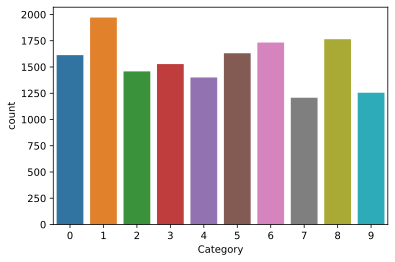

In [215]:
sns.countplot(x='Category', data=train_df)# drawing the distribution of classes

In [216]:
'''This is all images after combining'''

print(train.head())
print(train.info())

           Id  Category
0  296847.jpg         0
1  1cl783.jpg         0
2  254764.jpg         0
3  1cl293.jpg         0
4  1cl272.jpg         0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30601 entries, 0 to 1622
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        30601 non-null  object
 1   Category  30601 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 717.2+ KB
None


#### I've enriched the data in two times, It must take a good affect on the accuracy

<AxesSubplot:xlabel='Category', ylabel='count'>

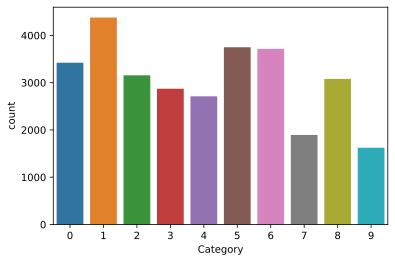

In [217]:
sns.countplot(x='Category', data=train)

#### The distribution of classes is differs on about two times by some classes. But I don't think that it is nessesary to drop something, because neural network can extact more parameters and the BatchNormalization will help us.  

In [218]:
'''Extracting test images, wich will have to categorize'''

with zipfile.ZipFile(DATA_PATH+'test.zip',"r") as z:
     z.extractall(PATH)
        
print(os.listdir(PATH))

['test_upload', 'pages.csv']


Images sample


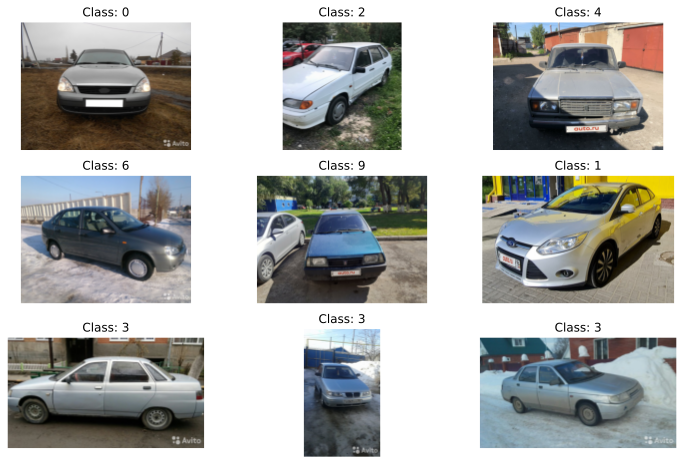

In [219]:
'''Let's look on the examples of images and there sizes, 
to see how we can better work with them.'''

print('Images sample')
plt.figure(figsize=(12,8))

random_image = train.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(MY_PATH+f'train_merged/train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()


In [220]:
'''Here I'll find a median value of images height, 
that will be used on step 4 to increase the IMG_SIZE '''

image_paths = train['Id'].values# filenames
image_cat = train['Category'].values# directory names
sizes = []# list of image sizes

for index, path in enumerate(image_paths):
    im = PIL.Image.open(MY_PATH+f'train_merged/train/{image_cat[index]}/{path}')
    sizes.append(im.size[1])# get the second part of resolution

print('Total amount of images: ',len(sizes))
print('Median value: ',np.median(sizes))

Total amount of images:  30601
Median value:  480.0


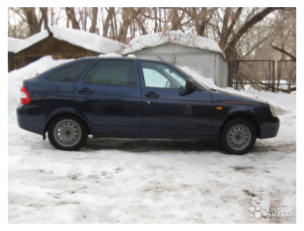

(640, 480)

In [221]:
'''The separate image'''

image = PIL.Image.open(MY_PATH+'train_merged/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.axis('off')
plt.show()
image.size

#### Later, when the model will be fixed, we'll try to increase the IMG_SIZE value. 

## 4. Data Preparing

### 4.1 Augmentation

In [222]:
"""Let's use augmentations to take more variants"""

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, 
                          interpolation=1, 
                          border_mode=4, 
                          value=None, 
                          mask_value=None, 
                          always_apply=False, 
                          p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, 
                                  width=200),
        albumentations.CenterCrop(height=200, 
                                  width=224)],
                         p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
                         p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, 
                            always_apply=False, 
                            p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

In [223]:
# Data loaders.
train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    seed=RANDOM_SEED,
    validation_split=VAL_SPLIT
)

test_datagen = ImageDataGenerator(
    #rescale=1./255
)


### 4.2 Data generation

In [224]:
'''Putting data into generator'''

train_generator = train_datagen.flow_from_directory(
    MY_PATH+'train_merged/train/',      
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training') # set as training data

val_generator = train_datagen.flow_from_directory(
    MY_PATH+'train_merged/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation') # set as validation data

test_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)


Found 24485 images belonging to 10 classes.
Found 6116 images belonging to 10 classes.
Found 6675 validated image filenames.


#### Let's look what we have in generators:

Example from train generator


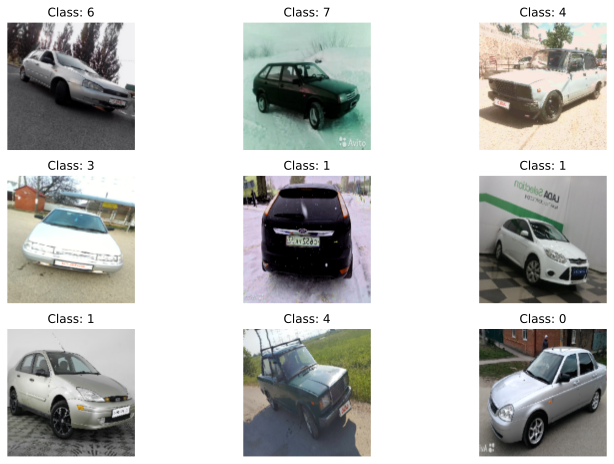

In [225]:
x,y = train_generator.next()
print('Example from train generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    plt.title('Class: '+str(list(y[i]).index(1)))
    plt.axis('off')
plt.show()


Example from val generator


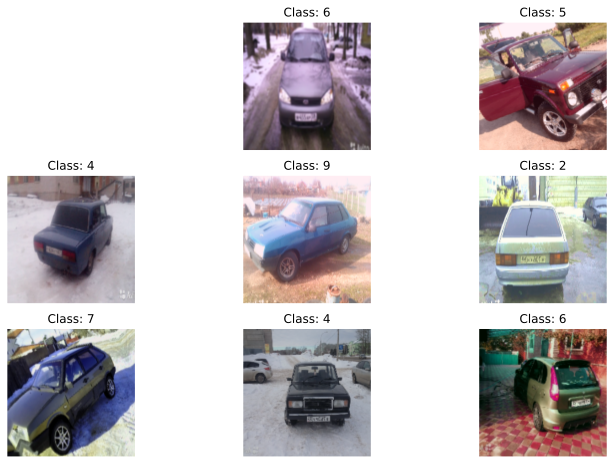

In [226]:
x,y = val_generator.next()
print('Example from val generator')
plt.figure(figsize=(12,8))

for i in range(1,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    plt.title('Class: '+str(list(y[i]).index(1)))
    plt.axis('off')
plt.show()


Example from test generator


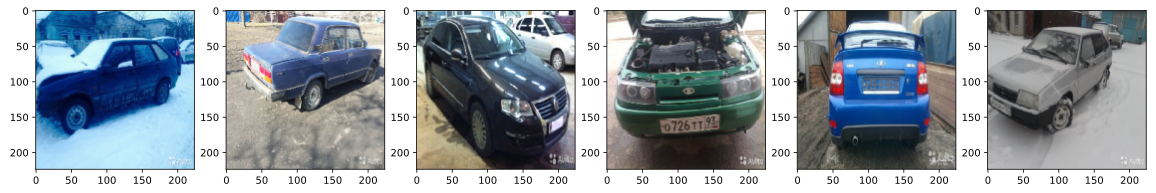

In [227]:
print('Example from test generator')
show_first_images(test_generator, labels=False)

## 5. Building model

### Downloading the net:

In [228]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

In [229]:
base_model.summary()


Model: "efficientnet-b6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 56) 1512        input_4[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 56) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [230]:
# first: train only the top layers (which were randomly initialized)
base_model.trainable = False

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  659


In [231]:
# Constructing the model:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(BatchNormalization())
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [232]:
# Thats what we have now:
model.summary()
for layer in model.layers:
    print(layer, layer.trainable)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 7, 7, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2304)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2304)              9216      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                23050     
Total params: 40,992,402
Trainable params: 27,658
Non-trainable params: 40,964,744
_________________________________________________________________
<tensorflow.python.keras.engine.functional.Functional object at 0x7f9e083fa190> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9d6f3f5090> True
<tensorflow.python.keras.layers.normalization_v2.BatchN

In [233]:
# Finally, assembling the model 
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR),
              metrics=["accuracy"])

## 6. Fitting the model

### Adding callbacks

In [234]:
# It is really neccesary to save models during the education,
# because the time of session is limited:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] ,
                              verbose = 1  , mode = 'max')

# Stop the education if the is no progress:
earlystop = EarlyStopping(monitor='val_accuracy', patience=3, 
                          restore_best_weights=True)

# Reduce learning rate if the is no progress:
reduce_lr = ReduceLROnPlateau( monitor='val_accuracy',factor=0.25,patience=2,
                               min_lr=1e-7,verbose=1,mode='auto')

callbacks_list = [checkpoint, earlystop,reduce_lr]


### Step 1

In [235]:
'''And now let's train our model 
(Here and later code will be commented, because the process is quite long)'''

# history = model.fit(
#                     train_generator,
#                     steps_per_epoch = train_generator.samples//train_generator.batch_size,
#                     validation_data = val_generator, 
#                     validation_steps = val_generator.samples//val_generator.batch_size,
#                     epochs = 10,
#                     callbacks = callbacks_list
#                     )

"And now let's train our model \n(Here and later code will be commented, because the process is quite long)"

In [236]:
# Saving the results:
# model.save('../working/model_step1.hdf5')
# model.load_weights('best_model.hdf5')
# plot_history(history)#draw the progrees of education

### Step 2

In [237]:
'''On this step we'll make half of layers trainable ''' 

base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

print("Number of trainable layers: ",len(base_model.trainable_variables))

Number of layers in the base model:  659
Number of trainable layers:  291


In [238]:
LR=0.1e-4 #downgrade the learnig rate  
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR),
              metrics=["accuracy"])

In [239]:
# history = model.fit(
#                     train_generator,
#                     steps_per_epoch = train_generator.samples//train_generator.batch_size,
#                     validation_data = val_generator, 
#                     validation_steps = val_generator.samples//val_generator.batch_size,
#                     epochs = 15,
#                     callbacks = callbacks_list
#                     )

In [240]:
# model.load_weights('best_model.hdf5')
# model.save('../working/step2.hdf5')
# plot_history(history)

### Step 3

In [241]:
'''As I've told above, the session has ended,
and I need to load the model  '''

model = M.load_model(MOD_PATH+'step2.hdf5')


In [242]:
#Checking trainable parameters:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 7, 7, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2304)              9216      
_________________________________________________________________
dense (Dense)                (None, 10)                23050     
Total params: 40,992,402
Trainable params: 37,724,128
Non-trainable params: 3,268,274
_________________________________________________________________


In [243]:
#Making all layers trainable:
for layer in model.layers:
    layer.trainable =  True

In [244]:
# Now the whole model is trainable:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 7, 7, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2304)              9216      
_________________________________________________________________
dense (Dense)                (None, 10)                23050     
Total params: 40,992,402
Trainable params: 40,763,362
Non-trainable params: 229,040
_________________________________________________________________


In [245]:
LR=1e-4
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR),
              metrics=["accuracy"])



In [246]:
# history = model.fit(
#                     train_generator,
#                     steps_per_epoch = train_generator.samples//train_generator.batch_size,
#                     validation_data = val_generator, 
#                     validation_steps = val_generator.samples//val_generator.batch_size,
#                     epochs = 20,
#                     callbacks = callbacks_list
#                     )

In [247]:
# model.load_weights('best_model.hdf5')
# model.save('../working/step3.hdf5')
# plot_history(history)

### Step 4

#### On This step I'll increase the image size and retrain the model  

In [248]:
'''Deleting previous generators'''
del (AUGMENTATIONS,
    train_datagen,
    train_generator,
    val_generator 
    )

In [249]:
EPOCHS               = 8 # This is the maximum to not exeed the session time
BATCH_SIZE           = 5 # decrease the batch size
LR                   = 1e-4

IMG_SIZE             = 480
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [250]:
"""Here I'll drop out the center crop to let the net find out more qualities"""

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, 
                          interpolation=1, 
                          border_mode=4, 
                          value=None, 
                          mask_value=None, 
                          always_apply=False, 
                          p=0.5),
        albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
                         p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, 
                            always_apply=False, 
                            p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

In [251]:
'''Now we need to remake the generators:'''

train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    seed=RANDOM_SEED,
    validation_split=VAL_SPLIT
)


In [252]:
train_generator = train_datagen.flow_from_directory(
    MY_PATH+'train_merged/train/',      
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training') # set as training data

val_generator = train_datagen.flow_from_directory(
    MY_PATH+'train_merged/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation') # set as validation data


Found 24485 images belonging to 10 classes.
Found 6116 images belonging to 10 classes.


Example from train generator


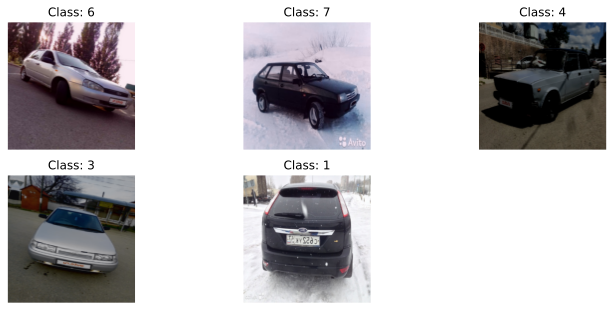

In [253]:
x,y = train_generator.next()
print('Example from train generator')
plt.figure(figsize=(12,8))

for i in range(0,5):# reduce the range according to batch
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    plt.title('Class: '+str(list(y[i]).index(1)))
    plt.axis('off')
plt.show()


In [254]:
model = M.load_model(MOD_PATH+'step4_13.hdf5')# loading model from previous step

In [255]:
model.summary()
for layer in model.layers:
    print(layer, layer.trainable)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 7, 7, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2304)              9216      
_________________________________________________________________
dense (Dense)                (None, 10)                23050     
Total params: 40,992,402
Trainable params: 40,763,362
Non-trainable params: 229,040
_________________________________________________________________
<tensorflow.python.keras.engine.functional.Functional object at 0x7f999c598ad0> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9929bba390> True
<tensorflow.python.keras.layers.normalization_v2.BatchNor

In [256]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=LR),
              metrics=['accuracy'])


In [257]:
'''Changing callbacks:'''

checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] ,
                              verbose = 1  , mode = 'max')


earlystop = EarlyStopping(monitor='val_accuracy', patience=5, # increase the value of patience
                          restore_best_weights=True)

# Reduce learning rate if the is no progress:
reduce_lr = ReduceLROnPlateau( monitor='val_accuracy',factor=0.25,patience=2,
                               min_lr=1e-7,verbose=1,mode='auto')

callbacks_list = [checkpoint, earlystop,reduce_lr]


In [258]:
# history = model.fit(
#                     train_generator,
#                     steps_per_epoch = train_generator.samples//train_generator.batch_size,
#                     validation_data = val_generator, 
#                     validation_steps = val_generator.samples//val_generator.batch_size,
#                     epochs = EPOCHS,
#                     callbacks = callbacks_list
#                     )

In [259]:
# model.load_weights('best_model.hdf5')
# model.save('../working/step4.hdf5')

In [260]:
# plot_history(history)

### Here are the plots of step 4 education:

###                      Epochs 1-8
![Getting Started](Ep8.jpg)

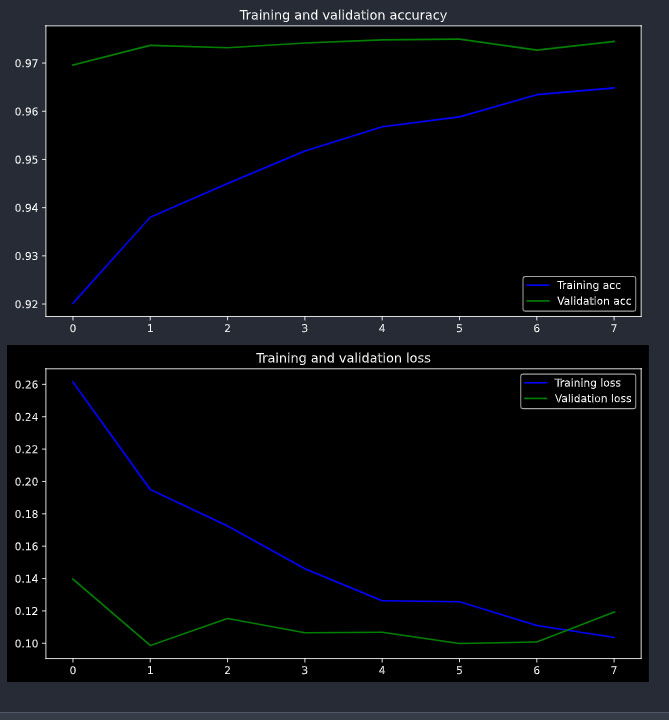

### Epochs 9-16
![Getting Started](Ep16.jpg)
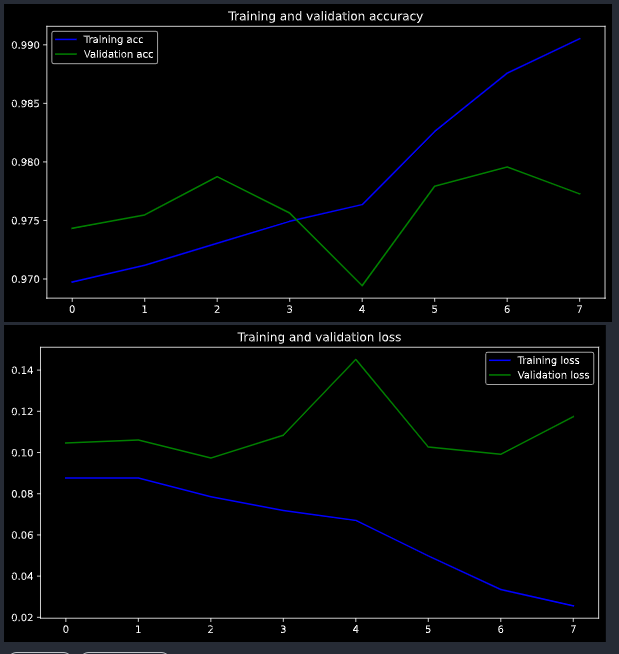

### As we can see, the model has overfitted after 12-th epoch 

## 7. Test Time Augmentation

#### Here I will use the augmentations to the test images and predict several times on them, then choose the mean value of prediction.

In [261]:
del test_datagen,test_generator#deleting old generator

In [262]:
AUGMENT_TEST = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, 
                          interpolation=1, 
                          border_mode=4, 
                          value=None, 
                          mask_value=None, 
                          always_apply=False, 
                          p=0.5),
        albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
                         p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

Found 6675 validated image filenames.


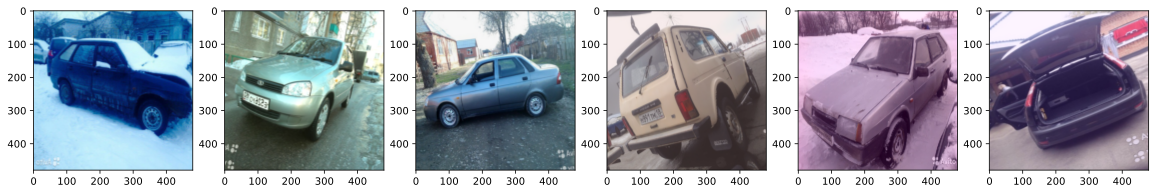

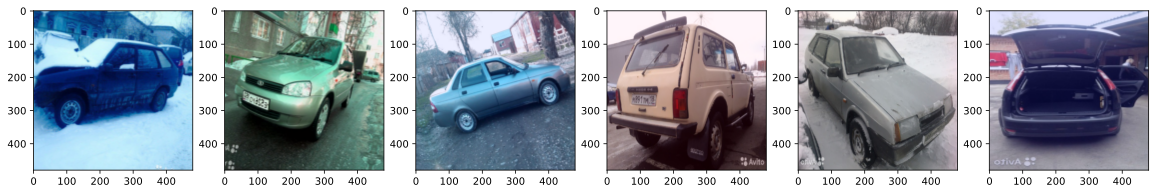

In [263]:
'''Using augmentations and make new generator'''

def augment(image):
    image = image.astype(np.uint8)
    return AUGMENT_TEST(image=image)['image']

test_datagen = ImageDataGenerator(
    preprocessing_function=augment
    )

test_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

show_first_images(test_generator, labels=False)
test_generator.reset()
show_first_images(test_generator, labels=False)

In [264]:
# test_generator.reset()
# tta_steps = 2 # number of steps to loop over
# pred_list = []# list with all predictions

# for i in range(tta_steps):
#     preds = model.predict(test_generator,steps=len(test_generator),verbose=1) 
#     pred_list.append(preds)
#     test_generator.reset()


In [265]:
# pred = np.mean(pred_list, axis=0)# taking the mean value
# predictions = np.argmax(pred, axis=-1) 


#### I have failed with this method - the accuracy is near 0,10, In the future I should learn TTA better and deal with it. 

## 8. Ensembling.

### Here I'll make an ensemble of model predictions on three epochs.

#### Accuracy on several epochs of step 4:
* S4ep12 : 0.97558
* S4ep13 : 0.97573
* S4ep14 : 0.97123

In [266]:
del test_datagen,test_generator#deleting old generator

In [267]:
"""Making new generator"""

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)



Found 6675 validated image filenames.


In [268]:
'''Making predictions on several epochs: '''

S4ep12 = M.load_model(MOD_PATH+'step4_12.hdf5')
ep12 = S4ep12.predict(test_generator, steps=len(test_generator), verbose=1)

S4ep13 = M.load_model(MOD_PATH+'step4_13.hdf5')
ep13 = S4ep13.predict(test_generator, steps=len(test_generator), verbose=1)

S4ep14 = M.load_model(MOD_PATH+'step4_14.hdf5')
ep14 = S4ep14.predict(test_generator, steps=len(test_generator), verbose=1)

1335/1335 [==============================] - 158s 116ms/step


In [269]:
predictions = 0.3*ep12+ 0.5*ep13 + 0.2*ep14# Adding predictions according to their accuracy
predictions = predictions.argmax(axis=1)
predictions

array([2, 6, 4, ..., 1, 3, 4])

## 9. Submission

In [270]:
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [271]:
''' Here is submission with accuracy 0.97797 on leaderboard'''
submission.head()

,Id,Category
0,305108.jpg,2
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


## Conclusion

### During this work I've used these methods to improve the accuracy:

#### * Enriching the train data twice by parser
#### * Advanced augmentations with albumentations library
#### * Callbacks during the education
#### * EfficientNetB6 with transfer learning and fine-tuning
#### * Test time augmentation (failed)
#### * Ensemling the models

### History of submissions:

#### 1. At first I've used the EfficientNetB6 with freezing layers (3 steps) and got 0.9537;
#### 2. Then I've added the albumentations and got 0.96779;
#### 3. After downloading new images the accuracy has rised only to 0.96794;
#### 4. Then, on step 4, after increasing the image size I've got 0.97573 on 13'th epoch;
#### 5. As I said above, I've could not use the TTA correctly;
#### 6. And, finally after ensemling three models, the result was 0.97797.  

#### During the TTA I've used three methods: augmentation with datagenerator, albumentations and keras layers. It seems like I've missed thomething, so in the future I will investigate this theme. 

#### At first look, there were no result of enriching the data, but it may took an effect after the image size increasing. Now I have no time to check this hypothesis, but in comparing with other competitors I've got a good result and I think it has an influence.


